In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, '../src')

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms as T

from tqdm.autonotebook import tqdm
from torchsummaryX import summary

from model import Generator
from space_modules import SceneEncoder
from data_utils import ImageFilelistMultiscale, show_batch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [22]:
dataset = ImageFilelistMultiscale('/storage1/datasets/CLEVR_v1.0/images/train/', '*.png', resolutions=((64,64), (128, 128)))
subset = torch.utils.data.Subset(dataset, list(range(256)))

loader = torch.utils.data.DataLoader(
    subset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
)
batch64, batch128 = next(iter(loader))

In [43]:
scene_encoder = SceneEncoder().to(device)
summary(scene_encoder, batch)

                                                        Kernel Shape  \
Layer                                                                  
0_img_encoder.conv_layers.0.Conv2d_0                   [3, 16, 4, 4]   
1_img_encoder.conv_layers.0.GroupNorm_1                         [16]   
2_img_encoder.conv_layers.0.CELU_2                                 -   
3_img_encoder.conv_layers.1.Conv2d_0                  [16, 32, 4, 4]   
4_img_encoder.conv_layers.1.GroupNorm_1                         [32]   
5_img_encoder.conv_layers.1.CELU_2                                 -   
6_img_encoder.conv_layers.2.Conv2d_0                  [32, 64, 4, 4]   
7_img_encoder.conv_layers.2.GroupNorm_1                         [64]   
8_img_encoder.conv_layers.2.CELU_2                                 -   
9_img_encoder.conv_layers.3.Conv2d_0                 [64, 128, 3, 3]   
10_img_encoder.conv_layers.3.GroupNorm_1                       [128]   
11_img_encoder.conv_layers.3.CELU_2                             

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_img_encoder.conv_layers.0.Conv2d_0,"[3, 16, 4, 4]","[2, 16, 64, 64]",784.0,3145728.0
1_img_encoder.conv_layers.0.GroupNorm_1,[16],"[2, 16, 64, 64]",32.0,16.0
2_img_encoder.conv_layers.0.CELU_2,-,"[2, 16, 64, 64]",NaN,NaN
3_img_encoder.conv_layers.1.Conv2d_0,"[16, 32, 4, 4]","[2, 32, 32, 32]",8224.0,8388608.0
4_img_encoder.conv_layers.1.GroupNorm_1,[32],"[2, 32, 32, 32]",64.0,32.0
5_img_encoder.conv_layers.1.CELU_2,-,"[2, 32, 32, 32]",NaN,NaN
6_img_encoder.conv_layers.2.Conv2d_0,"[32, 64, 4, 4]","[2, 64, 16, 16]",32832.0,8388608.0
7_img_encoder.conv_layers.2.GroupNorm_1,[64],"[2, 64, 16, 16]",128.0,64.0
8_img_encoder.conv_layers.2.CELU_2,-,"[2, 64, 16, 16]",NaN,NaN


In [48]:
encoded_scene = scene_encoder(batch)
print(encoded_scene.keys())
z_bg = encoded_scene['bg_feats']
print('Background features:', z_bg.size())
view_in_bg = encoded_scene['bg_transform_params']
print('Background transform params:', view_in_bg.size())
z_fg = encoded_scene['valid_img_feats']
print('Foreground features:', z_fg.size())
view_in_fg = encoded_scene['fg_transform_params']
print('Foreground transform params:', view_in_fg.size())

dict_keys(['img_feats', 'bg_feats', 'bg_transform_params', 'glimpses_info', 'obj_pres', 'valid_img_feats', 'valid_scale', 'valid_center', 'fg_transform_params'])
Background features: torch.Size([2, 64])
Background transform params: torch.Size([2, 9])
Foreground features: torch.Size([2, 137, 128])
Foreground transform params: torch.Size([2, 137, 9])


In [51]:
generator = Generator(z_dim_bg=64, z_dim_fg=128, use_learnable_proj=False, use_inverse_transform=False).to(device)

In [74]:
generated = generator(z_bg=z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)

/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


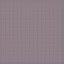

In [77]:
T.functional.to_pil_image(generated[0])

In [80]:
summary(generator, z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)

                                                         Kernel Shape  \
Layer                                                                   
0_bg_generator.adain0.Linear_z_proj                         [64, 512]   
1_bg_generator.adain0.ReLU_relu                                     -   
2_bg_generator.adain0.InstanceNorm3d_ins_norm                       -   
3_bg_generator.LeakyReLU_lrelu                                      -   
4_bg_generator.deconvs.ConvTranspose3d_0          [128, 256, 3, 3, 3]   
5_bg_generator.adains.0.Linear_z_proj                       [64, 256]   
6_bg_generator.adains.0.ReLU_relu                                   -   
7_bg_generator.adains.0.InstanceNorm3d_ins_norm                     -   
8_bg_generator.LeakyReLU_lrelu                                      -   
9_bg_generator.deconvs.ConvTranspose3d_1           [64, 128, 3, 3, 3]   
10_bg_generator.adains.1.Linear_z_proj                      [64, 128]   
11_bg_generator.adains.1.ReLU_relu                 

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_bg_generator.adain0.Linear_z_proj,"[64, 512]","[2, 512]",33280.0,32768.0
1_bg_generator.adain0.ReLU_relu,-,"[2, 512]",NaN,NaN
2_bg_generator.adain0.InstanceNorm3d_ins_norm,-,"[2, 256, 4, 4, 4]",NaN,NaN
3_bg_generator.LeakyReLU_lrelu,-,"[2, 256, 4, 4, 4]",NaN,NaN
4_bg_generator.deconvs.ConvTranspose3d_0,"[128, 256, 3, 3, 3]","[2, 128, 8, 8, 8]",884864.0,452984832.0
5_bg_generator.adains.0.Linear_z_proj,"[64, 256]","[2, 256]",16640.0,16384.0
6_bg_generator.adains.0.ReLU_relu,-,"[2, 256]",NaN,NaN
7_bg_generator.adains.0.InstanceNorm3d_ins_norm,-,"[2, 128, 8, 8, 8]",NaN,NaN
8_bg_generator.LeakyReLU_lrelu,-,"[2, 128, 8, 8, 8]",NaN,NaN


# Overfit

In [ ]:
batch64, batch128

In [23]:
torch.autograd.set_detect_anomaly(False)

In [ ]:
bsz = 4
# in_batch = batch128[:bsz].to(device)
# out_batch = batch64[:bsz].to(device)
loader = torch.utils.data.DataLoader(
    subset,
    batch_size=bsz,
    shuffle=True,
    pin_memory=True,
)

generator = Generator(
    z_dim_bg=64, 
    z_dim_fg=128, 
    use_learnable_proj=False,
    use_inverse_transform=False
).to(device)
scene_encoder = SceneEncoder().to(device)

lr = 1e-4
optimizer = torch.optim.Adam([
    {'params': generator.parameters(), 'lr': lr},
    {'params': scene_encoder.parameters(), 'lr': lr}
], lr=1e-4)

l1_loss = nn.L1Loss()

num_epochs = 50
scene_encoder.zero_grad()
generator.zero_grad()

epoch_bar = tqdm(range(num_epochs), total=num_epochs)
for epoch in epoch_bar:
    pbar = tqdm(loader, total=len(loader))
    for batch64, batch128 in pbar:
        in_batch = batch128.to(device)
        out_batch = batch64.to(device)
        encoded_scene = scene_encoder(in_batch)
        z_bg = encoded_scene['bg_feats']
        view_in_bg = encoded_scene['bg_transform_params']
        z_fg = encoded_scene['valid_img_feats']
        view_in_fg = encoded_scene['fg_transform_params']

        generated = generator(z_bg=z_bg, z_fg=z_fg, view_in_bg=view_in_bg, view_in_fg=view_in_fg)
        loss = l1_loss(generated, out_batch)

        loss.backward()
        optimizer.step()

        scene_encoder.zero_grad()
        generator.zero_grad()

        pbar.set_postfix(
            loss=loss.item(),
            num_objs=z_fg.size(1),
        )

/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/samenabar/.venvs/grievous/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [15]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

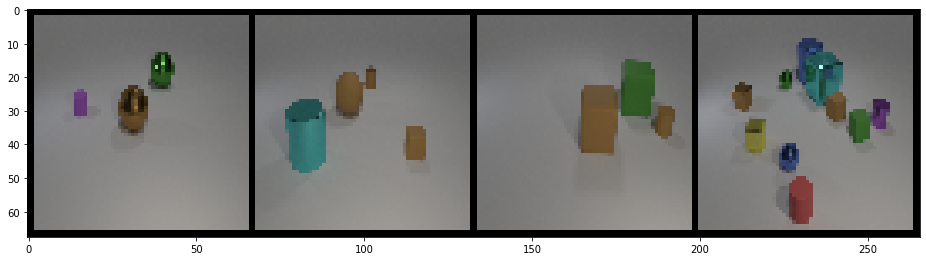

In [20]:
fig = plt.figure(figsize=(16, 10))
plt.imshow(T.functional.to_pil_image(make_grid(out_batch).cpu()))

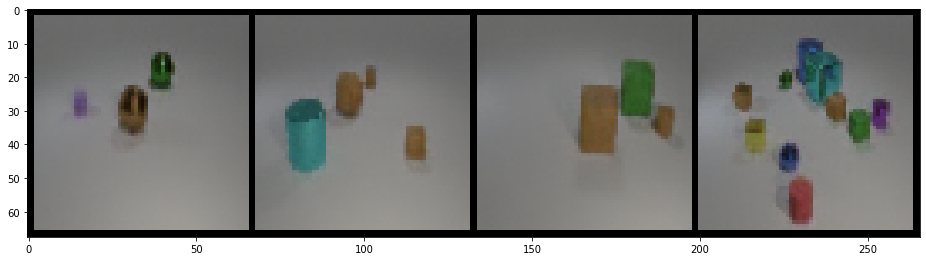

In [21]:
fig = plt.figure(figsize=(16, 10))
plt.imshow(T.functional.to_pil_image(make_grid(generated).cpu()))